### fusion

In [1]:
import os
import sys 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import *
#scipy.signal.convolve2d

abs_path=os.path.abspath(os.curdir)
cvlib_path=abs_path+"/../cvlib/"
sys.path.append(cvlib_path)
from convs import *
from sobel import *

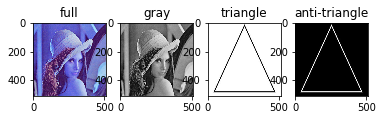

In [2]:
originImage = cv2.imread("../lena.jpg")
grayImage = cv2.cvtColor(originImage,cv2.COLOR_BGR2GRAY)
originImage32x32 = cv2.imread("../lena_32x32.jpg")
grayImage32x32 = cv2.cvtColor(originImage32x32,cv2.COLOR_BGR2GRAY)
plt.subplot(1, 4, 1)
plt.title("full")
plt.imshow(originImage)
plt.subplot(1, 4, 2)
plt.title("gray")
plt.gray()
plt.imshow(grayImage)

triangleImage = cv2.imread("../triangle512x512.jpg")
graytriangleImage = cv2.cvtColor(triangleImage,cv2.COLOR_BGR2GRAY)
plt.subplot(1, 4, 3)
plt.title("triangle")
plt.gray()
plt.imshow(triangleImage)
graytriangleImage_anti=255-graytriangleImage
plt.subplot(1, 4, 4)
plt.title("anti-triangle")
plt.gray()
plt.imshow(graytriangleImage_anti)

#### Gaussian pyramid
1. sigmas
    
    1. 高斯金字塔有O组金字塔,每组内部是分辨率相同但是filter尺度不同的图像.
    O组的最大如下(向下取整):
    $$O=log_2min(X,Y)-2$$
    
    2. 单一组内金字塔的层数S(Lowe建议s为3)
    $$S=s+3$$
    
    3, 但一组内每层的sigma,sigma0是基层的.
    $$\sigma _0,k\sigma _0,k^2\sigma _0,k^3\sigma _0,k^4\sigma _0$$
    
    4. k的确定,s为小s.
    $$k=2^{\frac{1}{s}}$$
    $$\sigma=k^r\sigma_0;  r\in[0,...,s+2]$$
    
    5. 每组外,靠金字塔上的一组是本组的down size.
    
    6. 第1组的sigma
    $$\sigma=2k^r\sigma_0;  r\in[0,...,s+2]$$
    
    
> 综合:
    $$\sigma(o,r)=\sigma_02^{o+\frac{r}{s}}$$
    
2. gaussian filter

3. downsize



In [3]:
def downsize(src,stride=2):
    w,h=src.shape
    dest=np.zeros((int(w/2),int(h/2)),np.float32)
    for i in range(int(w/2)):
        for j in range(int(h/2)):
            dest[i,j]=src[i*2,j*2]
    return dest
def upsize(src,stride=2):
    w,h=src.shape
    dest=np.zeros((int(w*2),int(h*2)),np.float32)
    for i in range(int(w)):
        for j in range(int(h)):
            dest[i*stride,j*stride]=src[i,j]
            dest[i*stride+1,j*stride+1]=0
    return dest
    

In [4]:
def Gaussian_pyramid(src,sigma,layer,group):
    #gf_img=Gaussian_filter(src=src,sigma=1.3, k_h=3,k_w=3)
    # step1 calc sigmas
    s=layer
    sigmas=np.zeros((s+3,1),np.float32)
    S=s+3
    k=np.power(2,1.0/s)
    sigmas[0]=sigma
    for layeridx in range(1,s+3):
        sig_prev=np.power(k,layeridx-1)*sigmas[0]
        sig_cur=sig_prev*k
        sig_guassian=np.sqrt(sig_cur**2-sig_prev**2)
        sigmas[layeridx]=sig_guassian
    print("k:%s",k)
    #return sigmas
    print(sigmas)
    dest={}
    for o in range(group):
        for i in range(s+3):
            if o==0 and i==0:
                temp=src.copy()
                dest[(o,i)]=src
            elif i==0:
                temp=dest[(o-1,s)].copy()
                #print("o:%s,i:%s,shape:%s"%(o,i,temp.shape))
                dest[(o,i)]=downsize(temp,2)
                #print("dest[o:%s,i:%s]:%s"%(o,i,dest[(o,i)].shape))
            else:
                temp=dest[(o,i-1)].copy()
                dest[(o,i)]=Gaussian_filter(temp,sigmas[i],7,7)
                #dest[(o,i)]=cv2.GaussianBlur(temp,(7,7),sigmas[i])
                print(dest[(o,i)].shape)
     
    return dest,sigmas

In [5]:
dict_img,sigmas=Gaussian_pyramid(grayImage,1.5,3,3)


k:%s 1.2599210498948732
[[1.5      ]
 [1.1496314]
 [1.4484448]
 [1.824926 ]
 [2.2992628]
 [2.8968897]]
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(128),r(3):sw(128)]:
after crop: dest.shape:(128,128)
(128, 128)
dest[r(3):sh(128),r(3):sw(128)]:
after crop: dest.

---
##### cv2 Gaussian kernel
```python
A=cv2.getGaussianKernel(3,1.5)
B=A*A.T
print(B)
print(Gaussian_filter(dict_img[(0,0)],1.5,3,3))
```

##### np crop array

```python
A={}
A[(0,0)]=(1,2)
A[(0,1)]=(3,4)
print(A)
```
```python
A=np.array([[1,2,3,4],[4,5,6,4],[7,8,9,4]])
B=A[1:3,1:3]
B
```
---

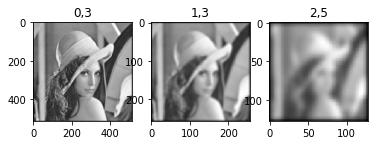

In [6]:
plt.subplot(1, 3, 1)
plt.title("0,3")
plt.imshow(dict_img[(0,3)])
plt.subplot(1, 3, 2)
plt.title("1,3")
plt.imshow(dict_img[(1,3)])
plt.subplot(1, 3, 3)
plt.title("2,5")
plt.imshow(dict_img[(2,5)])

8.669242


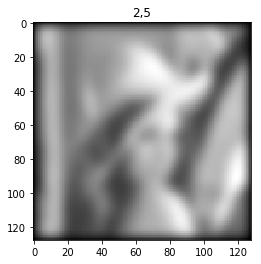

In [7]:
plt.subplot(1, 1, 1)
plt.title("2,5")
plt.imshow(dict_img[(2,5)])
print(dict_img[(2,5)][127,127])

### Laplacian pyramid

In [8]:
def Laplacian_pyramid(gDict,group,layer,sigmas):
    lap_dest={}
    for o in range(group-1):
        for s in range(layer+3): # 少一层 
            # 高斯当前层
            gcurLayer=gDict[(o,s)]
            # 高斯上一层
            gUpperLayer=gDict[(o+1,s)]
            gUpSizeUpperLayer=upsize(gUpperLayer,2)
            gUpSizeUpperLayerGuass=Gaussian_filter(gUpSizeUpperLayer,sigmas[s],7,7)
            #print("gcurLayer.shape:",gcurLayer.shape)
            #print("gUpSizeUpperLayerGuass.shape:",gUpSizeUpperLayerGuass.shape)
            minw=min(gcurLayer.shape[0],gUpSizeUpperLayerGuass.shape[0])
            if gcurLayer.shape[0]!=minw:
                gcurLayer=gcurLayer[:minw,:minw]
            if gUpSizeUpperLayerGuass.shape[0]!=minw:
                gUpSizeUpperLayerGuass=gUpSizeUpperLayerGuass[:minw,:minw]
            lap_dest[(o,s)]=gcurLayer-gUpSizeUpperLayerGuass
    return lap_dest

In [9]:
lap_img=Laplacian_pyramid(dict_img,3,3,sigmas)

dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)


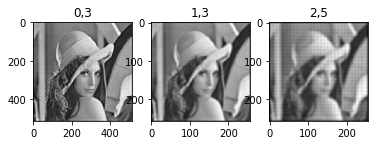

In [10]:
plt.subplot(1, 3, 1)
plt.title("0,3")
plt.imshow(lap_img[(0,3)])
plt.subplot(1, 3, 2)
plt.title("1,3")
plt.imshow(lap_img[(1,2)])
plt.subplot(1, 3, 3)
plt.title("2,5")
plt.imshow(lap_img[(1,4)])

### tow image fusion

In [11]:
def image_fusion(src1,src2):
    o=3
    s=3
    dict_src1,sigmas_src1=Gaussian_pyramid(src1,1.5,3,3)
    lap_src1=Laplacian_pyramid(dict_src1,3,3,sigmas_src1)
    dict_src2,sigmas_src2=Gaussian_pyramid(src2,1.5,3,3)
    lap_src2=Laplacian_pyramid(dict_src2,3,3,sigmas_src2)
    
    
    lap_fusion_img={}
    
    for oi in range(o-1):
        for si in range(s-1):
            src1_lap_temp=lap_src1[(oi,si)]
            src2_lap_temp=lap_src2[(oi,si)]
            
            minw=min(src1_lap_temp.shape[0],src2_lap_temp.shape[0])
            if src1_lap_temp.shape[0]!=minw:
                src1_lap_temp=src1_lap_temp[:minw,:minw]
            if src2_lap_temp.shape[0]!=minw:
                src2_lap_temp=src2_lap_temp[:minw,:minw]
            
            w,h=src1_lap_temp.shape
            temp=np.zeros((w,h),np.float32)
            for i in range(w):
                for j in range(h):
                    if src1_lap_temp[i,j] < src2_lap_temp[i,j]:
                        temp[i,j]=src2_lap_temp[i,j]
                    else:
                        temp[i,j]=src1_lap_temp[i,j]
            
            lap_fusion_img[(oi,si)]=temp
    w,h=src1.shape
    #restore_img=np.zeros((w,h),np.float32)
    restore_img=lap_fusion_img[(0,0)]
    for oi in range(1,o-1):
        for si in range(1,s-1):
            temp=lap_fusion_img[(oi,si)]
            tempUpper=upsize(temp,2)
            tempUpperGuassian=Gaussian_filter(tempUpper,sigmas_src1[s],7,7)
            if tempUpperGuassian.shape[0]!=w:
                tempUpperGuassian=tempUpperGuassian[:w,:w]
            restore_img+=tempUpperGuassian
    
    return restore_img,lap_src1,dict_src1,lap_src2,dict_src2,lap_fusion_img


        
    
    

In [12]:
fusion_img,lap_src1,dict_src1,lap_src2,dict_src2,lap_fusion_img=image_fusion(grayImage,graytriangleImage_anti)

k:%s 1.2599210498948732
[[1.5      ]
 [1.1496314]
 [1.4484448]
 [1.824926 ]
 [2.2992628]
 [2.8968897]]
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(128),r(3):sw(128)]:
after crop: dest.shape:(128,128)
(128, 128)
dest[r(3):sh(128),r(3):sw(128)]:
after crop: dest.

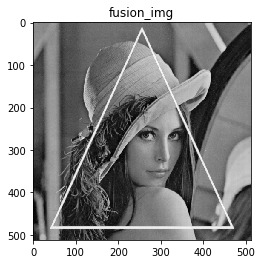

In [13]:
plt.subplot(1, 1, 1)
plt.title("fusion_img")
plt.imshow(fusion_img)
#print(fusion_img)

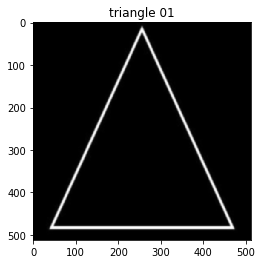

In [14]:
#lap_src1,dict_src1,lap_src2,dict_src2,lap_fusion_img
plt.subplot(1, 1, 1)
plt.title("triangle 01")
plt.imshow(dict_src2[(0,1)])
#print(fusion_img)

#### low and over jpg fusion

In [15]:
fusion_img,lap_src1,dict_src1,lap_src2,dict_src2,lap_fusion_img=image_fusion(grayImage,graytriangleImage_anti)

k:%s 1.2599210498948732
[[1.5      ]
 [1.1496314]
 [1.4484448]
 [1.824926 ]
 [2.2992628]
 [2.8968897]]
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(128),r(3):sw(128)]:
after crop: dest.shape:(128,128)
(128, 128)
dest[r(3):sh(128),r(3):sw(128)]:
after crop: dest.

k:%s 1.2599210498948732
[[1.5      ]
 [1.1496314]
 [1.4484448]
 [1.824926 ]
 [2.2992628]
 [2.8968897]]
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(128),r(3):sw(128)]:
after crop: dest.shape:(128,128)
(128, 128)
dest[r(3):sh(128),r(3):sw(128)]:
after crop: dest.

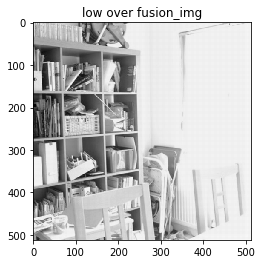

In [16]:
lowImage = cv2.imread("../low_exp.jpg")
graylowImage = cv2.cvtColor(lowImage,cv2.COLOR_BGR2GRAY)

overImage = cv2.imread("../over_exp.jpg")
grayoverImage = cv2.cvtColor(overImage,cv2.COLOR_BGR2GRAY)



lo_fusion_img,lo_lap_src1,lo_dict_src1,lo_lap_src2,lo_dict_src2,lo_lap_fusion_img=image_fusion(graylowImage,grayoverImage)

plt.subplot(1, 1, 1)
plt.title("low over fusion_img")
plt.imshow(lo_fusion_img)


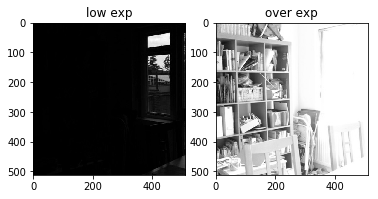

In [17]:
plt.subplot(1, 2, 1)
plt.title("low exp")
plt.imshow(graylowImage)
plt.subplot(1, 2, 2)
plt.title("over exp")
plt.gray()
plt.imshow(grayoverImage)


#### hdr with mask reconstruction

In [18]:
def image_fusion_with_mask(src1,src2,mask):
    o=3
    s=3
    dict_src1,sigmas_src1=Gaussian_pyramid(src1,1.5,3,3)
    lap_src1=Laplacian_pyramid(dict_src1,3,3,sigmas_src1)
    dict_src2,sigmas_src2=Gaussian_pyramid(src2,1.5,3,3)
    lap_src2=Laplacian_pyramid(dict_src2,3,3,sigmas_src2)
    dict_mask,sigmas_mask=Gaussian_pyramid(mask,1.5,3,3)
    lap_mask=Laplacian_pyramid(dict_src2,3,3,sigmas_mask)
    
    
    lap_fusion_img={}
    
    for oi in range(o-1):
        for si in range(s-1):
            src1_lap_temp=lap_src1[(oi,si)]
            src2_lap_temp=lap_src2[(oi,si)]
            mask_lap_temp=lap_mask[(oi,si)]
            
            minw=min(src1_lap_temp.shape[0],src2_lap_temp.shape[0])
            if src1_lap_temp.shape[0]!=minw:
                src1_lap_temp=src1_lap_temp[:minw,:minw]
            if src2_lap_temp.shape[0]!=minw:
                src2_lap_temp=src2_lap_temp[:minw,:minw]
            
            w,h=src1_lap_temp.shape
            temp=np.zeros((w,h),np.float32)
            for i in range(w):
                for j in range(h):
                    #(im1_pyramid[i] * (1.0 - mask_pyramid[i]) + im2_pyramid[i] * mask_pyramid[i])
                    '''
                    if src1_lap_temp[i,j] < src2_lap_temp[i,j]:
                        temp[i,j]=src2_lap_temp[i,j]
                    else:
                        temp[i,j]=src1_lap_temp[i,j]
                    '''
                    temp[i,j]=src1_lap_temp[i,j]*(255-mask_lap_temp[i,j])+src2_lap_temp[i,j]*mask_lap_temp[i,j]
            lap_fusion_img[(oi,si)]=temp
    w,h=src1.shape
    #restore_img=np.zeros((w,h),np.float32)
    restore_img=lap_fusion_img[(0,0)]
    for oi in range(1,o-1):
        for si in range(1,s-1):
            temp=lap_fusion_img[(oi,si)]
            tempUpper=upsize(temp,2)
            tempUpperGuassian=Gaussian_filter(tempUpper,sigmas_src1[s],7,7)
            if tempUpperGuassian.shape[0]!=w:
                tempUpperGuassian=tempUpperGuassian[:w,:w]
            restore_img+=tempUpperGuassian
    
    return restore_img,lap_src1,dict_src1,lap_src2,dict_src2,lap_fusion_img


        
    
    

In [19]:
maskImage = cv2.imread("../mask.jpg")
graymaskImage = cv2.cvtColor(lowImage,cv2.COLOR_BGR2GRAY)


masklo_fusion_img,masklo_lap_src1,masklo_dict_src1,masklo_lap_src2,masklo_dict_src2,masklo_lap_fusion_img=image_fusion_with_mask(graylowImage,grayoverImage,graymaskImage)



k:%s 1.2599210498948732
[[1.5      ]
 [1.1496314]
 [1.4484448]
 [1.824926 ]
 [2.2992628]
 [2.8968897]]
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(512),r(3):sw(512)]:
after crop: dest.shape:(512,512)
(512, 512)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(256),r(3):sw(256)]:
after crop: dest.shape:(256,256)
(256, 256)
dest[r(3):sh(128),r(3):sw(128)]:
after crop: dest.shape:(128,128)
(128, 128)
dest[r(3):sh(128),r(3):sw(128)]:
after crop: dest.

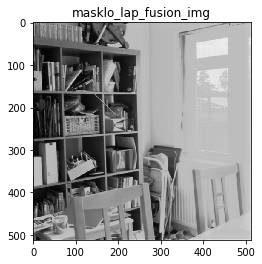

In [20]:
plt.subplot(1, 1, 1)
plt.title("masklo_lap_fusion_img")
plt.imshow(masklo_fusion_img)